## Imports

In [1]:
import torch
import os
import json
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [3]:
%run ../iu_xray.py

In [4]:
REPORTS_DIR = os.path.join(DATASET_DIR, 'reports')

## Load data

In [29]:
reports_fname = os.path.join(reports_dir, 'reports.json')
with open(reports_fname, 'r') as f:
    reports_as_dict = json.load(f)
    reports = list(reports_as_dict.values())
len(reports_as_dict), len(reports)

(3955, 3955)

In [30]:
info_fname = os.path.join(DATASET_DIR, 'info.json')
with open(info_fname, 'r') as f:
    info = json.load(f)
len(info)

2

In [65]:
with open(info_fname, 'w') as f:
    json.dump(info, f)

In [34]:
info['marks']['rotated_left']

['CXR947_IM-2442-1001.png',
 'CXR994_IM-2478-1001.png',
 'CXR2146_IM-0766-13013.png']

### Rotate images

NOTE: are already rotated!!

In [55]:
rotations = [
    ('left', -90),
    ('right', 90),
    ('bottom', 180),
]

In [ ]:
for key, degrees in rotations:
    images_key = f'rotated_{key}'
    for image_name in info['marks'][images_key]:
        filepath = os.path.join(DATASET_DIR, 'images', image_name)
        img = Image.open(filepath).rotate(degrees)
        # img.save(filepath)

## Clean text

### Tokenize and clean

In [36]:
import re
from collections import defaultdict, Counter

In [37]:
# text = 'The previously<BR>described XXXX deformity'
text = """1. low lung volumes
2. exam limited on lateral view by superimposed soft tissue and bony structures of the arm
3. lungs appear grossly clear . no evidence of pneumonia .
4. heart and pulmonary xxxx appear normal
5. pleural spaces are clear
6. mediastinal contours appear normal
7. no acute cardiopulmonary disease on this exam
8."""
re.sub(r'< ?br ?\\?>', ' ', text.lower())

'1. low lung volumes\n2. exam limited on lateral view by superimposed soft tissue and bony structures of the arm\n3. lungs appear grossly clear . no evidence of pneumonia .\n4. heart and pulmonary xxxx appear normal\n5. pleural spaces are clear\n6. mediastinal contours appear normal\n7. no acute cardiopulmonary disease on this exam\n8.'

In [38]:
def remove_consecutive_dots(tokens):
    clean_tokens = []
    last_was_dot = False
    for token in tokens:
        is_dot = (token == '.')
        if last_was_dot and is_dot:
            continue

        clean_tokens.append(token)
        last_was_dot = is_dot
            
    return clean_tokens

In [39]:
remove_consecutive_dots(['.', '.', 'asdf', 'hello', '.', 'abc', '.', '.', 'c', '.'])

['.', 'asdf', 'hello', '.', 'abc', '.', 'c', '.']

In [40]:
NUMBER_TOKEN = 'NUMBER'

def text_to_tokens(text):
    text = text.lower()
    text = re.sub(r'(\[)?&amp;[gl]t;(\])?', ' ', text)
    
    text = re.sub(r'(;|,+)', r',', text)
    
    text = re.sub(r'\d+(\.|/)\d+', NUMBER_TOKEN, text)
    
    text = re.sub(r'< ?br ?\\?>', ' ', text)
    text = re.sub(r'[\[\]<>]', '', text)
    text = re.sub(r'(\(|\))', r' \1 ', text)
    
    text = re.sub(r'\.+', r'.', text)
    text = re.sub(r'([a-zA-Z])(\.|,|/)', r'\1 \2', text)
    text = re.sub(r'(\.|,|/)([a-zA-Z])', r'\1 \2', text)
    
    text = re.sub(r'\d+\.[^\d]', r' . ', text) # Enumerators, like "1. bla bla, 2. bla bla"
    text = re.sub(r'(\d)\.', r'\1 .', text)
    
    text = re.sub(r'([^\w])\d+(a|st|nd|th|rd|\%|mm|xxxx)?', f'\1 {NUMBER_TOKEN}', text)
    
    text = re.sub(r'NUMBER\.', 'NUMBER .', text)
    
    tokens = remove_consecutive_dots(text.split())
    if tokens[0] == '.':
        tokens = tokens[1:]
        
    if tokens[-1] != '.':
        tokens.append('.')
    return tokens

In [35]:
text_to_tokens(text)

NameError: name 'text' is not defined

In [41]:
IGNORE_TOKENS = set(['p.m.'])
token_appearances = Counter()
errors = defaultdict(list)

cleaned_reports_as_dict = dict()

for report in reports:
    filename = report['filename']
    findings = report['findings']
    impression = report['impression']

    n_images = len(report['images'])
    if n_images == 0:
        errors['no-images'].append(filename)
        continue
    
    text = findings
    if findings is None and impression is None:
        errors['text-none'].append(filename)
        continue
    elif findings is None:
        errors['findings-none'].append(filename)
        text = impression
    elif impression is None:
        errors['impression-none'].append(filename)

    # Clean and tokenize text
    tokens = [token for token in text_to_tokens(text) if token not in IGNORE_TOKENS]
    token_appearances += {
        token: 1
        for token in tokens
    }

    cleaned_report = {k: v for k, v in report.items()}
    cleaned_report['clean_text'] = ' '.join(tokens)

    cleaned_reports_as_dict[filename] = cleaned_report

print({k: len(v) for k, v in errors.items()})
print(len(token_appearances))
len(cleaned_reports_as_dict), len(reports)

{'findings-none': 489, 'impression-none': 6}
1878


(3826, 3826)

In [42]:
len([k for k, v in token_appearances.items() if v > 1])

1274

In [43]:
sorted([(k, v) for k, v in token_appearances.items() if re.search(r'(NUM|\d)', k)],
       key=lambda x:x[1], reverse=False)

[('t7,', 1),
 ('4', 1),
 ('t5', 1),
 ('l2', 1),
 ('t12-l1', 1),
 ('t8,', 1),
 ('l2-l', 1),
 ('l4', 1),
 ('s1', 1),
 ('13', 1),
 ('t6', 1),
 ('t4', 1),
 ('l3', 1),
 ('t12,', 1),
 ('l1-l', 1),
 ('t9-t10', 1),
 ('l1', 2),
 ('l1,', 2),
 ('t7', 2),
 ('t10', 3),
 ('t6,', 3),
 ('t11', 4),
 ('3', 4),
 ('NUMBER\x01', 4),
 ('t9', 5),
 ('t12', 6),
 ('2', 20),
 ('NUMBER', 201)]

### Review errors

In [197]:
reports_as_dict[errors['no-images'][0]]

IndexError: list index out of range

### Review specific tokens

In [289]:
found = []

for report in cleaned_reports_as_dict.values():
    name = report['filename']
    text = report['findings']
    
    clean = report.get('clean_text', None)
    if not clean:
        try:
            clean = cleaned_reports_as_dict[name]['clean_text']
        except:
            pass
    
    if clean is None:
        continue
        
    s = re.search(r' \d+ ', clean)
    if s:
        found.append((name, text, clean)) # s.group(0)

print(len(found))
found

0


[]

### Save cleaned reports

NOTE: Save after image info below

In [44]:
fname = os.path.join(REPORTS_DIR, 'reports.clean.v2.json')
with open(fname, 'w') as f:
    json.dump(cleaned_reports_as_dict, f)

## Add side to image info (in cleaned reports)

`side` can be one of (`frontal`, `lateral-left`, `lateral-right`)

In [44]:
fname = os.path.join(reports_dir, 'reports.clean.json')
with open(fname, 'r') as f:
    clean_reports = json.load(f)
len(clean_reports)

3826

In [45]:
wrong_images = set(info['marks']['wrong'])
broken_images = set(info['marks']['broken'])

In [46]:
for report_name, report_dict in clean_reports.items():
    new_images_info = []
    for image_info in report_dict['images']:
        image_name = image_info['id']
        image_name = f'{image_name}.png'

        image_info['side'] = info['classification'][image_name]
        image_info['wrong'] = image_name in wrong_images
        image_info['broken'] = image_name in broken_images

        new_images_info.append(image_info)
    
    report_dict['images'] = new_images_info
    clean_reports[report_name] = report_dict
    
len(clean_reports)

3826

In [47]:
fname = os.path.join(reports_dir, 'reports.clean.json')
with open(fname, 'w') as f:
    json.dump(clean_reports, f)

## Save common vocab

In [45]:
%run ../vocab/__init__.py
%run ../iu_xray.py

In [46]:
train_dataset = IUXRayDataset(dataset_type='train', recompute_vocab=True)
len(train_dataset)

5923

In [47]:
vocab = train_dataset.get_vocab()
len(vocab)

1741

In [48]:
prev_vocab = load_vocab('iu_xray')
len(prev_vocab), len(vocab)

(1741, 1741)

In [49]:
idx = 1000
a = [(k, v) for k, v in vocab.items() if v == idx][0]
b = [(k, v) for k, v in prev_vocab.items() if v == idx][0]
a, b

(('persistently', 1000), ('persistently', 1000))

In [50]:
save_vocab('iu_xray', vocab)

## Calculate image normalization

In [1]:
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [19]:
%run ../../utils/images.py

In [5]:
image_folder = os.path.join(DATASET_DIR, 'images')

In [10]:
dataset = IUXRayDataset('train')
len(dataset)

5923

In [14]:
train_images = [
    i if i.endswith('.png') else f'{i}.png'
    for i in [r['image_name'] for r in dataset.reports]
]
len(train_images)

5923

In [20]:
mean, std = compute_mean_std(ImageFolderIterator(image_folder, train_images), show=True)
mean, std

(tensor([0.4821, 0.4821, 0.4821]), tensor([0.2374, 0.2374, 0.2374]))

### Plot average image

In [ ]:
from torchvision import transforms

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [ ]:
summed = torch.zeros(3, 256, 256)

for image_name in tqdm(image_names):
    fpath = os.path.join(image_folder, image_name)
    image = transform(Image.open(fpath).convert('RGB'))
    summed += image
    
summed /= len(image_names)

In [11]:
average_image = summed.mean(dim=0)
average_image.size()

torch.Size([256, 256])

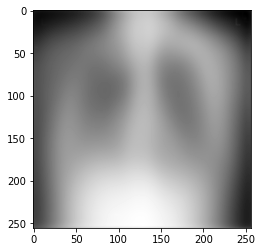

In [16]:
plt.imshow(average_image, cmap='gray')

## Test `IUXrayDataset` class

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms

In [5]:
%run ../iu_xray.py

In [6]:
dataset = IUXRayDataset(dataset_type='all', frontal_only=True)
len(dataset), len(dataset.word_to_idx)

(3800, 1775)

In [60]:
item = dataset[0]
image = item.image
labels = item.labels
report = item.report
image.size(), labels.size(), len(report)

(torch.Size([3, 512, 512]), torch.Size([14]), 4)

In [ ]:
plt.imshow(image.numpy().transpose(1, 2, 0))

In [66]:
dataset.get_labels_presence_for('Cardiomegaly')

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0),
 (10, 0),
 (11, 0),
 (12, 0),
 (13, 0),
 (14, 0),
 (15, 0),
 (16, 0),
 (17, 0),
 (18, 0),
 (19, 0),
 (20, 1),
 (21, 1),
 (22, 0),
 (23, 0),
 (24, 0),
 (25, 0),
 (26, 0),
 (27, 0),
 (28, 0),
 (29, 0),
 (30, 0),
 (31, 0),
 (32, 0),
 (33, 0),
 (34, 0),
 (35, 0),
 (36, 0),
 (37, 0),
 (38, 0),
 (39, 0),
 (40, 0),
 (41, 0),
 (42, 0),
 (43, 1),
 (44, 1),
 (45, 0),
 (46, 0),
 (47, 0),
 (48, 0),
 (49, 0),
 (50, 0),
 (51, 0),
 (52, 0),
 (53, 0),
 (54, 0),
 (55, 0),
 (56, 0),
 (57, 0),
 (58, 0),
 (59, 0),
 (60, 0),
 (61, 0),
 (62, 0),
 (63, 0),
 (64, 0),
 (65, 0),
 (66, 0),
 (67, 0),
 (68, 0),
 (69, 0),
 (70, 0),
 (71, 0),
 (72, 1),
 (73, 1),
 (74, 0),
 (75, 0),
 (76, 0),
 (77, 0),
 (78, 0),
 (79, 1),
 (80, 0),
 (81, 0),
 (82, 0),
 (83, 0),
 (84, 0),
 (85, 0),
 (86, 0),
 (87, 0),
 (88, 0),
 (89, 0),
 (90, 0),
 (91, 0),
 (92, 0),
 (93, 0),
 (94, 0),
 (95, 0),
 (96, 0),
 (97, 0),
 (98, 0),
 (99, 0),
 (100, 0),

### Review different image shapes

In [205]:
shapes = set()

for idx in range(len(dataset)):
    image, _ = dataset[idx]
    shapes.add(image.numpy().shape)

len(shapes)

251

In [206]:
shapes

{(3, 378, 512),
 (3, 391, 512),
 (3, 392, 512),
 (3, 399, 512),
 (3, 403, 512),
 (3, 409, 512),
 (3, 413, 512),
 (3, 415, 512),
 (3, 419, 512),
 (3, 420, 512),
 (3, 421, 512),
 (3, 422, 512),
 (3, 423, 512),
 (3, 424, 512),
 (3, 425, 512),
 (3, 426, 512),
 (3, 428, 512),
 (3, 429, 512),
 (3, 430, 512),
 (3, 431, 512),
 (3, 433, 512),
 (3, 434, 512),
 (3, 435, 512),
 (3, 436, 512),
 (3, 437, 512),
 (3, 441, 512),
 (3, 442, 512),
 (3, 443, 512),
 (3, 446, 512),
 (3, 447, 512),
 (3, 448, 512),
 (3, 449, 512),
 (3, 450, 512),
 (3, 451, 512),
 (3, 454, 512),
 (3, 456, 512),
 (3, 457, 512),
 (3, 459, 512),
 (3, 460, 512),
 (3, 461, 512),
 (3, 462, 512),
 (3, 463, 512),
 (3, 464, 512),
 (3, 466, 512),
 (3, 467, 512),
 (3, 468, 512),
 (3, 469, 512),
 (3, 470, 512),
 (3, 471, 512),
 (3, 472, 512),
 (3, 473, 512),
 (3, 474, 512),
 (3, 475, 512),
 (3, 476, 512),
 (3, 478, 512),
 (3, 479, 512),
 (3, 480, 512),
 (3, 481, 512),
 (3, 482, 512),
 (3, 483, 512),
 (3, 484, 512),
 (3, 485, 512),
 (3, 486

### Load single images

In [11]:
fname = DATASET_DIR + '/images/CXR5_IM-2117-1003002.png'
img = Image.open(fname)
img_tensor = transforms.ToTensor()(img)
img.size, img_tensor.size()

((512, 621), torch.Size([3, 621, 512]))

## Inspect tags

In [14]:
from collections import defaultdict

In [15]:
counter = defaultdict(lambda: 0)
for report in reports:
    tags = report['tags_manual']
    for tag in tags:
        counter[tag] += 1

In [23]:
len(reports)

3955

In [22]:
sorted(((k, v) for k, v in counter.items()), key=lambda x:x[1], reverse=True)

[('normal', 1391),
 ('Lung/hypoinflation', 245),
 ('Lung/hyperdistention', 164),
 ('Cardiomegaly', 157),
 ('Cardiomegaly/mild', 135),
 ('Aorta/tortuous', 126),
 ('Spine/degenerative', 115),
 ('Thoracic Vertebrae/degenerative', 114),
 ('Granulomatous Disease', 98),
 ('Atherosclerosis/aorta', 97),
 ('No Indexing', 95),
 ('Thoracic Vertebrae/degenerative/mild', 93),
 ('Technical Quality of Image Unsatisfactory ', 86),
 ('Calcinosis/aorta', 69),
 ('Markings/bronchovascular', 68),
 ('Aorta, Thoracic/tortuous', 59),
 ('Catheters, Indwelling/right', 54),
 ('Emphysema', 54),
 ('Pulmonary Congestion', 52),
 ('Pulmonary Atelectasis/base/left', 51),
 ('Pulmonary Disease, Chronic Obstructive', 50),
 ('Spondylosis/thoracic vertebrae', 49),
 ('Spine/degenerative/mild', 48),
 ('Cardiomegaly/borderline', 47),
 ('Opacity/lung/base/left', 46),
 ('Pulmonary Atelectasis/base/bilateral', 44),
 ('Lung/hyperdistention/mild', 40),
 ('Implanted Medical Device/left', 39),
 ('Diaphragm/right/elevated', 38),
 ('C

## Get sample reports

For LATINX in AI workshop

In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from pycocoevalcap.bleu import bleu_scorer
from pycocoevalcap.rouge import rouge

In [3]:
%run ../common.py
%run ../iu_xray.py
%run ../../utils/nlp.py
%run ../../utils/__init__.py

In [39]:
CONSTANT_REPORT = """the heart is normal in size . the mediastinum is unremarkable . 
the lungs are clear .
there is no pneumothorax or pleural effusion . no focal airspace disease .
no pleural effusion or pneumothorax ."""

In [40]:
dataset = IUXRayDataset(dataset_type='all')
report_reader = ReportReader(dataset.get_vocab())
len(dataset)

7426

the cardiac silhouette is mildly enlarged . a lobulated opacity is identified superior to the heart , in the anterior mediastinum on the lateral view , possibly consistent with a tortuous / ectatic thoracic aorta versus an anterior mediastinal mass . the thoracic aorta is tortuous and calcified . no focal areas of pulmonary consolidation . the lungs are hyperexpanded with flattening of the bilateral hemidiaphragms . no pneumothorax or pleural effusion . severe degenerative changes of the thoracic spine .


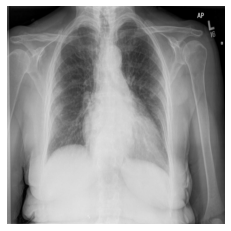

In [52]:
idx = GT_IDX
item = dataset[idx]
image = arr_to_range(item.image.permute(1, 2, 0))
report_base = report_reader.idx_to_text(item.report)
plt.imshow(image)
plt.axis('off')
print(report_base)

In [50]:
GT_IDX = 7289

In [41]:
target = [
    'the cardiac silhouette is enlarged',
    # 'the lungs are hyper',
    # 'the heart is',
]
not_target = [
    # 'the lungs are clear',
#     'the mediastinum is unremarkable',
#     'the mediastinum is stable',
#     'the mediastinum is normal',
#     'the mediastinum is within normal limits',
]
found = []
found_names = set()
for idx, report in enumerate(dataset.reports):
    filename = report['filename']
    report = report_reader.idx_to_text(report['tokens_idxs'])
    if all(t in report for t in target) and all(t not in report for t in not_target):
        if filename not in found_names:
            found.append((idx, report))
        found_names.add(filename)
len(found)

6

In [49]:
found[5]

(7354,
 'the cardiac silhouette is enlarged with no comparison studies . findings are xxxx accentuated by low lung volumes and eventration of the anterior right hemidiaphragm , however , cardiomegaly or less xxxx , pericardial effusion is suspected . the lungs are hypoinflated with central bronchovascular crowding but no evidence of overt pulmonary edema . the lungs are grossly clear of focal airspace disease , pneumothorax , pleural effusion . there are no acute bony findings . there are degenerative changes of the thoracic spine . patient appears morbidly obese .')

In [143]:
gen = 'the heart is enlarged. the mediastinum is unremarkable . the lungs are hyperinflated with mildly coarsened interstitial markings . '
# the lungs are hyperexpanded
# the lungs are hyperinflated with mildly coarsened interstitial markings
# the lungs are hyperinflated with biapical pleural-parenchymal scarring and upward retraction of the xxxx

In [23]:
def measure_bleu_rouge(gen, gt):
    scorer = bleu_scorer.BleuScorer(n=4)
    scorer += (gen, [gt])
    bleu_1_4, _ = scorer.compute_score()
    
    scorer = rouge.Rouge()
    rouge_score = scorer.calc_score([gen], [gt])
    
    print('BLEU 1-4: ', bleu_1_4)
    print('BLEU: ', np.mean(bleu_1_4))
    print('ROUGE-L: ', rouge_score)

In [10]:
report_1 = """the heart is normal in size . the mediastinum is unremarkable . 
the lungs are clear ."""
report_2 = """the heart is normal . the mediastinum is otherwise unremarkable . 
lungs are both clear ."""
measure_bleu_rouge(report_1, report_2)

BLEU 1-4:  [0.823529411716263, 0.6806139096884855, 0.498031475650019, 0.36447528422896314]
BLEU:  0.5916625203209327
ROUGE:  0.7922077922077921


In [86]:
report = report_reader.idx_to_text(dataset[GT_IDX].report)
report

'the cardiac silhouette is mildly enlarged . a lobulated opacity is identified superior to the heart , in the anterior mediastinum on the lateral view , possibly consistent with a tortuous / ectatic thoracic aorta versus an anterior mediastinal mass . the thoracic aorta is tortuous and calcified . no focal areas of pulmonary consolidation . the lungs are hyperexpanded with flattening of the bilateral hemidiaphragms . no pneumothorax or pleural effusion . severe degenerative changes of the thoracic spine .'

In [63]:
gt = """the cardiac silhouette is enlarged .
the lungs are hyperexpanded with flattening of the bilateral hemidiaphragms .
no pneumothorax or pleural effusion ."""
# the lungs are hyperinflated with mildly coarsened interstitial markings .
# with flattening of the bilateral hemidiaphragms 

In [64]:
gen = """the cardiac silhouette is normal in size .
the lungs are clear .
no pneumothorax or pleural effusion ."""

In [65]:
measure_bleu_rouge(gen, gt)

BLEU 1-4:  [0.6395982117214318, 0.58775019547367, 0.5291550092647807, 0.4606142784620598]
BLEU:  0.5542794237304856
ROUGE-L:  0.6714648602878917


In [77]:
gt = "the cardiac silhouette is enlarged . the lungs are hyperexpanded with flattening of the bilateral hemidiaphragms . no pneumothorax or pleural effusion ."
gen = "the cardiac silhouette is normal in size and configuration . the lungs are clear . no pneumothorax or pleural effusion ."
measure_bleu_rouge(gen, gt)

BLEU 1-4:  [0.6493974591358048, 0.5951826025196549, 0.5343297171373826, 0.46369919062449266]
BLEU:  0.5606522423543338
ROUGE-L:  0.6762749445676276


In [13]:
measure_bleu_rouge(gen, gt)

BLEU 1-4:  [0.6493974591358048, 0.5951826025196549, 0.5343297171373826, 0.46369919062449266]
BLEU:  0.5606522423543338
ROUGE:  0.644191714053615


## Check no-findings vs labels==0

In [5]:
from collections import defaultdict

In [6]:
chexpert_path = os.path.join(REPORTS_DIR, 'reports_with_chexpert_labels.csv')
mirqi_path = os.path.join(REPORTS_DIR, 'reports_with_mirqi_labels.csv')

In [7]:
chexpert_df = pd.read_csv(chexpert_path, index_col=0)
chexpert_df.replace(-1, 1, inplace=True)
chexpert_df.replace(-2, 0, inplace=True)
chexpert_df.head()

,Reports,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,filename
0,the cardiac silhouette and mediastinum size ar...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.xml
1,the cardiomediastinal silhouette is within nor...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.xml
2,both lungs are clear and expanded . heart and ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.xml
3,there is xxxx increased opacity within the rig...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1000.xml
4,interstitial markings are diffusely prominent ...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1001.xml


In [13]:
mirqi_df = pd.read_csv(mirqi_path, index_col=0)
mirqi_df.drop(columns=['attributes-gen', 'MIRQI-r', 'MIRQI-p', 'MIRQI-f'], inplace=True)
mirqi_df.rename(columns={'attributes-gt': 'attributes'}, inplace=True)
mirqi_df.replace(-1, 1, inplace=True)
mirqi_df.replace(-2, 0, inplace=True)
mirqi_df.head()

,filename,Reports,attributes,Airspace Disease,Airspace Opacity,Atelectasis,Calcinosis,Cardiomegaly,Consolidation,Edema,...,Hernia,Hypoinflation,Lung Lesion,Other Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Scoliosis,Support Devices
0,1.xml,the cardiac silhouette and mediastinum size ar...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.xml,the cardiomediastinal silhouette is within nor...,(contour|Enlarged Cardiomediastinum|NEGATIVE|)...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100.xml,both lungs are clear and expanded . heart and ...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1000.xml,there is xxxx increased opacity within the rig...,(mass|Lung Lesion|UNCERTAIN|possible) (consoli...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1001.xml,interstitial markings are diffusely prominent ...,(interstitial markings|Other Finding|POSITIVE|...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
base_columns = set(['filename', 'Reports', 'attributes'])
MIRQI_LABELS = [c for c in mirqi_df.columns if c not in base_columns]

In [14]:
len(chexpert_df), len(mirqi_df)

(3826, 3826)

In [16]:
df = chexpert_df.merge(mirqi_df, on='filename', suffixes=['_chx', '_mirqi'])
print(len(df))
df.head()

3826


,Reports_chx,No Finding,Enlarged Cardiomediastinum_chx,Cardiomegaly_chx,Lung Lesion_chx,Lung Opacity,Edema_chx,Consolidation_chx,Pneumonia_chx,Atelectasis_chx,...,Hernia,Hypoinflation,Lung Lesion_mirqi,Other Finding,Pleural Effusion_mirqi,Pleural Other_mirqi,Pneumonia_mirqi,Pneumothorax_mirqi,Scoliosis,Support Devices_mirqi
0,the cardiac silhouette and mediastinum size ar...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,the cardiomediastinal silhouette is within nor...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,both lungs are clear and expanded . heart and ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,there is xxxx increased opacity within the rig...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,interstitial markings are diffusely prominent ...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
reports_by_condition = defaultdict(set)

for index, row in chexpert_df.iterrows():
    filename = row['filename']
    report = row['Reports']
    labels = row[CHEXPERT_LABELS]

    tup = (index, filename, report)

    no_findings = labels['No Finding']
    
    if no_findings == 1:
        reports_by_condition['no-findings-1'].add(tup)
        if any(l != 0 for l in labels[1:-1]):
            # Exclude no-findings and support-devices
            reports_by_condition['inconsistent'].add(tup)
    else:
        if not any(l != 0 for l in labels[1:-1]):
            reports_by_condition['no-findings-absent'].add(tup)
    
    if all(l != 1 for l in labels):
        reports_by_condition['no-1s'].add(tup)
    
[(k, len(v)) for k, v in reports_by_condition.items()]

[('no-findings-1', 1502), ('no-findings-absent', 675), ('no-1s', 644)]

In [19]:
l = list(reports_by_condition['no-findings-absent'])
l[:5]

[(1654,
  '256.xml',
  'postoperative changes are present in the left fifth rib . residual radiopaque sutures are also present in the left upper lobe . the lungs are clear with no infiltrates or masses . heart and mediastinum are normal .'),
 (987,
  '1930.xml',
  'the cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size . the lungs are mildly hypoinflated but grossly clear of focal airspace disease , pneumothorax , or pleural effusion . there are mild degenerative endplate changes in the thoracic spine . there are no acute bony findings .'),
 (3373,
  '575.xml',
  'the heart size and mediastinal silhouette are within normal limits for contour . the lungs are clear . no pneumothorax or pleural effusions . the xxxx are intact . stable calcified granuloma in the left lung .'),
 (200,
  '1189.xml',
  'normal heart size and hilar vascular markings . evidence of prior granulomatous disease . the lungs are clear without focal area of consolidation , pleural

In [24]:
mirqi_df.loc[mirqi_df['filename'] == '256.xml'][MIRQI_LABELS]

,Airspace Disease,Airspace Opacity,Atelectasis,Calcinosis,Cardiomegaly,Consolidation,Edema,Emphysema,Enlarged Cardiomediastinum,Fracture,Hernia,Hypoinflation,Lung Lesion,Other Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Scoliosis,Support Devices
1654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
l = list(reports_by_condition['no-1s'])
l[:10]

[('1652.xml',
  'dextroscoliosis of the thoracic spine . clear lungs bilaterally . no pneumothorax or pleural effusion . no acute bony abnormalities .'),
 ('2479.xml',
  'there is a right-sided chest xxxx identified whose distal tip projects over the svc . heart size is normal . low lung volumes with elevated right hemidiaphragm . the lungs are grossly clear . no focal infiltrate . no pleural effusion or pneumothorax . normal pulmonary vascularity . normal mediastinal and hilar contours . degenerative changes of the spine .'),
 ('398.xml',
  'no focal consolidation , pneumothorax or definite pleural effusion . heart size and pulmonary vascularity within normal limits , no mediastinal widening characteristic in appearance of vascular injury . right paratracheal calcifications suggest a previous granulomatous process . no acute osseous injury xxxx demonstrated .'),
 ('1268.xml',
  'the cardiomediastinal silhouette is normal size and configuration . the thoracic aorta is tortuous . pulmon

In [25]:
l = list(reports_by_condition['no-findings-1'])
l[:10]

[('176.xml',
  'cardiac and mediastinal contours are within normal limits . the lungs are clear . bony structures are intact .'),
 ('1915.xml',
  'both lungs are clear and expanded . heart and mediastinum normal .'),
 ('270.xml',
  'the cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size . the lungs are clear of focal airspace disease , pneumothorax , or pleural effusion . there are no acute bony findings .'),
 ('1078.xml',
  'the lungs are clear . there is no pleural effusion or pneumothorax . the heart and mediastinum are normal . the skeletal structures are normal .'),
 ('1323.xml',
  'the heart size and mediastinal silhouette are within normal limits for contour . the lungs are clear . no pneumothorax or pleural effusions . the xxxx are intact .'),
 ('2291.xml',
  'heart size is normal . the lungs are clear . there are no focal air space consolidations . no pleural effusions or pneumothoraces . the hilar and mediastinal contours are normal . norm